In [1]:

# cd drive/MyDrive/Colab\ Notebooks/


In [2]:
# ls

# Imports + Setup

In [23]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random

In [24]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [46]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
# DATA_DIR = "data/all_processed_time_reset"
DATA_DIR = "data/all_processed"
# DATA_DIR = "../../../data/Theoretical_VTDP"

# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [47]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time, filename):
    """Automatically computes cooling rates (C/s) from Time and TC_* columns"""
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    
    # # Calculate cooling rates for all temperature sensors
    # for col in df.columns:
    #     if col.startswith("TC_"):
    #         df[f"{col}_rate"] = df[col].diff() / df["Time"].diff()  # ΔT/Δt
    
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    df["filename"] = filename
    
    return df.iloc[1:]



# Load and Combine Data

In [48]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue

    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping (unmatched):", fname)
        continue

    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params, filename=fname)
    dataframes.append(df)
    
data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())

Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66069 entries, 0 to 66068
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  66069 non-null  int64  
 1   TC1_tip               66069 non-null  float64
 2   TC2                   66069 non-null  float64
 3   TC3                   66069 non-null  float64
 4   TC4                   66069 non-null  float64
 5   TC5                   66069 non-null  float64
 6   TC6                   66069 non-null  float64
 7   TC7                   66069 non-null  float64
 8   TC8                   66069 non-null  float64
 9   TC9                   66069 non-null  float64
 10  TC10                  66069 non-null  float64
 11  Theoretical_Temps_1   66069 non-null  float64
 

# H6 Only Dataset

In [ ]:
# dataframes = []
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith(".csv"):
#         continue

#     params = parse_filename_params(fname)
#     if params is None or params[3] is None:
#         print("Skipping (unmatched):", fname)
#         continue

#     h_val = params[0]
#     if h_val != h_map[6]:  # Only include h6 = 0.1575
#         print("Skipping (not h6):", fname)
#         continue

#     path = os.path.join(DATA_DIR, fname)
#     df = load_and_process_file(path, *params,filename=fname)
#     dataframes.append(df)
#     data = pd.concat(dataframes, ignore_index=True)
# print(data.info())
# print(data.head())


Skipping (not h6): h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_431s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_585s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_wr_surf0_368s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_115s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_wr_surf

# Preprocessing

In [ ]:
# if data is not None:
#     theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
#     # rate_cols = [c for c in data.columns if c.endswith("_rate")] 
#     filenames = data["filename"].reset_index(drop=True)

#     # X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols + rate_cols].copy()
#     X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()

#     X["filename"] = filenames
#     y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')
#     # y = data[[col for col in data.columns if col.startswith("TC") and not col.endswith("_rate")]].copy()
#     y_columns = y.columns

#     X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
#         X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
#     )
#     X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
#         X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
#     )

#     train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
#     val_filenames = X.loc[X_val_raw.index, "filename"].unique().tolist()
#     test_filenames = X.loc[X_test_raw.index, "filename"].unique().tolist()

#     print("Train Files:", train_filenames)
#     print("Val Files:", val_filenames)
#     print("Test Files:", test_filenames)

#     # Scaling
#     X_scaler = MinMaxScaler()
#     X_train_scaled = X_scaler.fit_transform(X_train_raw)
#     X_val_scaled = X_scaler.transform(X_val_raw)
#     X_test_scaled = X_scaler.transform(X_test_raw)

#     y_scaler = MinMaxScaler()
#     y_train_scaled = y_scaler.fit_transform(y_train_raw)
#     y_val_scaled = y_scaler.transform(y_val_raw)
#     y_test_scaled = y_scaler.transform(y_test_raw)

#     joblib.dump(X_scaler, "X_scaler.pkl")
#     joblib.dump(y_scaler, "y_scaler.pkl")

#     # Convert to tensors and create DataLoader
#     train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
#     val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_scaled, dtype=torch.float32))
#     test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Train Files: ['h6_flux88_abs20_wr_surf0_734s - Sheet1_processed.csv', 'h6_flux88_abs20_surf0_781s - Sheet2_processed.csv', 'h6_flux73_abs0_surf1_660s - Sheet1_processed.csv', 'h6_flux78_abs0_surf1_newSalt_466s - Sheet1_processed.csv', 'h6_flux73_abs0_surf0_511s - Sheet3_processed.csv', 'h6_flux88_abs92_surf0_628s - Sheet4_processed.csv', 'h6_flux88_abs20_surf1_830s - Sheet2_processed.csv', 'h6_flux78_abs0_surf0_523s - Sheet2_processed.csv', 'h6_flux73_abs0_surf0_868s - Sheet1_processed.csv', 'h6_flux88_abs0_graphDisc_surf0_759s - Sheet1_processed.csv', 'h2_flux88_abs92_surf0_115s - Sheet1_processed.csv', 'h6_flux88_abs92_surf0_630s - Sheet2_processed.csv', 'h3_flux88_abs25_wr_surf0_422s-Sheet1_processed.csv', 'h6_flux88_abs20_surf0_651s - Sheet4_processed.csv', 'h3_flux88_abs25_wr_surf0_746s-Sheet2_processed.csv', 'h6_flux73_abs0_surf1_754s - Sheet3_processed.csv', 'h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv', 'h6_flux78_abs0_surf0_450s - Sheet3_processed.csv', 'h6_flux88_abs2

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import joblib

SEED = 42  # For reproducibility

if data is not None:
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    filenames = data["filename"].reset_index(drop=True)

    # Optional: rate_cols can be included if needed
    # rate_cols = [c for c in data.columns if c.endswith("_rate")] 
    # X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols + rate_cols].copy()

    X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()
    X["filename"] = filenames

    y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')
    y_columns = y.columns

    # -------- FILE-WISE SPLIT STARTS HERE --------
    unique_files = data["filename"].unique()
    train_files, temp_files = train_test_split(unique_files, test_size=0.3, random_state=SEED)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED)

    train_idx = data["filename"].isin(train_files)
    val_idx = data["filename"].isin(val_files)
    test_idx = data["filename"].isin(test_files)

    X_train_raw = X[train_idx].drop(columns="filename").reset_index(drop=True)
    X_val_raw = X[val_idx].drop(columns="filename").reset_index(drop=True)
    X_test_raw = X[test_idx].drop(columns="filename").reset_index(drop=True)

    y_train_raw = y[train_idx].reset_index(drop=True)
    y_val_raw = y[val_idx].reset_index(drop=True)
    y_test_raw = y[test_idx].reset_index(drop=True)

    # -------- FILE NAMES for info/debug --------
    train_filenames = sorted(train_files.tolist())
    val_filenames = sorted(val_files.tolist())
    test_filenames = sorted(test_files.tolist())

    print("Train Files:", train_filenames)
    print("Val Files:", val_filenames)
    print("Test Files:", test_filenames)

    # -------- SCALING --------
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train_raw)
    X_val_scaled = X_scaler.transform(X_val_raw)
    X_test_scaled = X_scaler.transform(X_test_raw)

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train_raw)
    y_val_scaled = y_scaler.transform(y_val_raw)
    y_test_scaled = y_scaler.transform(y_test_raw)

    joblib.dump(X_scaler, "X_scaler.pkl")
    joblib.dump(y_scaler, "y_scaler.pkl")

    # -------- DATA LOADERS --------
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                  torch.tensor(y_train_scaled, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                                torch.tensor(y_val_scaled, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                                 torch.tensor(y_test_scaled, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train Files: ['cleaned_h2_flux88_abs0_surf0_431s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs0_surf0_585s - Sheet2_processed.csv', 'cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv', 'cleaned_h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs25_surf0_493s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv', 'cleaned_h3_flux88_abs0_surf0_644s-Sheet2_processed.csv', 'cleaned_h3_flux88_abs0_surf0_719s-Sheet1_processed.csv', 'cleaned_h3_flux88_abs0_surf0_825s-Sheer3_processed.csv', 'cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv', 'cleaned_h3_flux88_abs25_surf0_660s-Sheet1_processed.csv', 'cleaned_h3_flux88_abs25_wr_surf0_422s-Sheet1_processed.csv', 'cleaned_h3_flux88_abs25_wr_surf0_746s-Sheet2_processed.csv', 'cleaned_h3_flux88_abs90_surf0_692s-Sheet2_processed.csv', 'cleaned_h3_flux88_abs90_surf0_747s-Sheet3_processed.csv', 

# Model

In [54]:
# Model with SiLU and Corrected Residual Connection
class EnhancedThermalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(0.3)

        self.layer1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, output_size)

        # Projection layer for residual connection
        self.residual_proj = nn.Linear(512, 256)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.silu(self.bn1(self.input_layer(x)))
        residual = self.residual_proj(x)
        x = self.dropout(x)
        
        x = self.silu(self.bn2(self.layer1(x)))
        x = self.silu(self.bn3(self.layer2(x)))
        x = x + residual
        x = self.dropout(x)
        
        x = self.silu(self.bn4(self.layer3(x)))
        return self.output_layer(x)


# Training

In [57]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
model = EnhancedThermalNet(
    input_size=X_train_scaled.shape[1],  # Automatically includes cooling rates
    output_size=y_train_scaled.shape[1]
                           ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

class EnhancedLoss(nn.Module):
    def __init__(self, smoothness_lambda=0.001):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_lambda = smoothness_lambda

    def forward(self, preds, targets):
        mse = self.mse_loss(preds, targets)
        smoothness = torch.mean(torch.abs(preds[:, 1:] - preds[:, :-1]))
        return mse + self.smoothness_lambda * smoothness

criterion = EnhancedLoss()
# Training Loop
EPOCHS = 1000
best_val_loss = float('inf')
patience = 50
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        train_loss = criterion(predictions, y_batch)
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += train_loss.item()
    
    train_loss_epoch /= len(train_loader)
    
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_preds = model(X_batch)
            val_loss = criterion(val_preds, y_batch)
            val_loss_epoch += val_loss.item()
    
    val_loss_epoch /= len(val_loader)
    scheduler.step()

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model_checkpoint.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss_epoch:.6f} Val Loss: {val_loss_epoch:.6f}")

# Load best model
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

Epoch [50/1000] Train Loss: 0.001684 Val Loss: 0.001419
Epoch [100/1000] Train Loss: 0.001435 Val Loss: 0.001587
Epoch [150/1000] Train Loss: 0.001557 Val Loss: 0.001513
Epoch [200/1000] Train Loss: 0.001601 Val Loss: 0.002154
Early stopping at epoch 217


<All keys matched successfully>

# Evaluation

In [60]:
# Evaluation
def evaluate_model(model, loader, scaler):
    model.eval()
    preds = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            preds.append(pred)
            y_true.append(y_batch.numpy())
    
    preds = np.concatenate(preds)
    y_true = np.concatenate(y_true)
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y_true)
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))
    mae = np.mean(np.abs(preds_real - y_real), axis=0)
    y_mean = np.mean(y_real, axis=0)
    ss_tot = np.sum((y_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((y_real - preds_real) ** 2, axis=0)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))
    return preds_real, y_real, rmse, mae, r2

preds_real, y_real, rmse, mae, r2 = evaluate_model(model, test_loader, y_scaler)

print("\n=== Comprehensive Evaluation ===")
print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R² Score':<12}")
for i, col in enumerate(y_columns):
    print(f"{col:<15} {rmse[i]:<12.3f} {mae[i]:<12.3f} {r2[i]:<12.3f}")
print(f"\nAverage RMSE: {np.mean(rmse):.3f} °C")
print(f"Average MAE: {np.mean(mae):.3f} °C")
print(f"Average R²: {np.mean(r2):.3f}")


=== Comprehensive Evaluation ===
Sensor          RMSE (°C)    MAE (°C)     R² Score    
TC1_tip         91.811       31.712       -0.132      
TC2             91.122       31.502       -0.120      
TC3             92.697       34.839       -0.188      
TC4             91.095       34.521       0.113       
TC5             90.461       34.339       0.305       
TC6             90.688       35.297       0.358       
TC7             92.154       36.911       0.405       
TC8             94.507       39.057       0.445       
TC9             98.079       45.795       0.432       
TC10            99.764       53.735       0.293       

Average RMSE: 93.238 °C
Average MAE: 37.771 °C
Average R²: 0.191


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

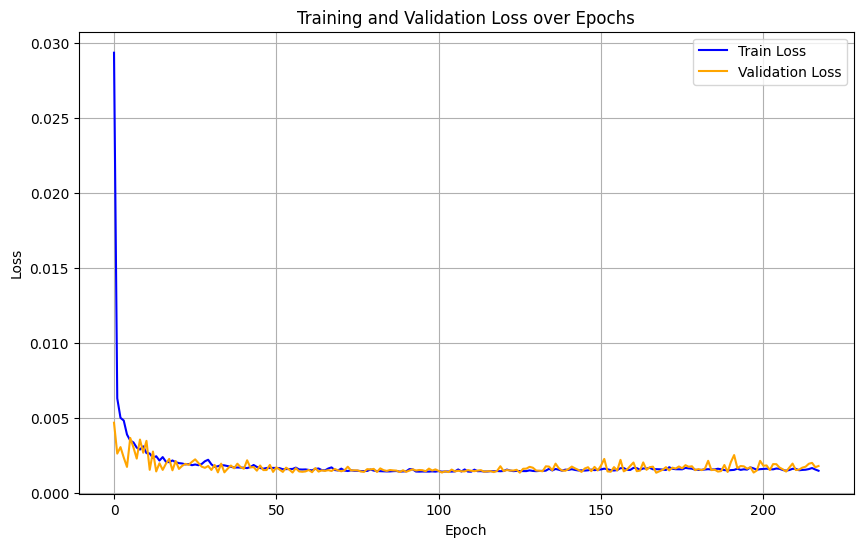

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
def check_and_clip_input(input_df, scaler):
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    columns = scaler.feature_names_in_
    clipped = False
    for i, col in enumerate(columns):
        val = input_df.iloc[0, i]
        if val < min_vals[i] or val > max_vals[i]:
            print(f"Warning: '{col}' value {val} is out of range [{min_vals[i]}, {max_vals[i]}]. Clipping.")
            input_df.iloc[0, i] = min(max(val, min_vals[i]), max_vals[i])
            clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [63]:
# Use a sample from the dataset for inference
# new_input = [[734, 0.1575, 25900, 20, 0.98] + [329.386266207629, 352.551499568358, 352.553759702364, 350.275738614983, 339.497145930202, 329.185115858301, 321.851178317625, 319.313289675805, 319.313289675805, 319.313289675805]]
# new_input = [[389, 0.1575, 25900, 20, 0.98]+[308.643914081496,329.496758659629,329.49784608407,327.585348377549,320.864532577509,315.25563745915,311.241414348336,309.692852226731,309.692852226731,309.692852226731]] 
new_input = [[0,0.1575,25900,20,0.98]+[322.346598107413,344.707379405421,344.707598403347,342.463078051269,332.928870144283,324.216781541098,318.02660925491,315.821244548393,315.821244548393,315.821244548393]]
theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = pd.DataFrame(new_input, columns=input_columns)
new_input_df = check_and_clip_input(new_input_df, X_scaler)  # Changed from new_input to new_input_df
new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(new_tensor).cpu().numpy()
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred.flatten().tolist())
# 359.94,359.37,360.24,360.78,359.9,362.01,358.77,359.11,355.59,330.85


Predicted Temperatures: [360.7577209472656, 360.9826354980469, 361.5712585449219, 358.35858154296875, 356.2557678222656, 358.66033935546875, 358.3454895019531, 361.6995544433594, 363.049072265625, 347.2612609863281]


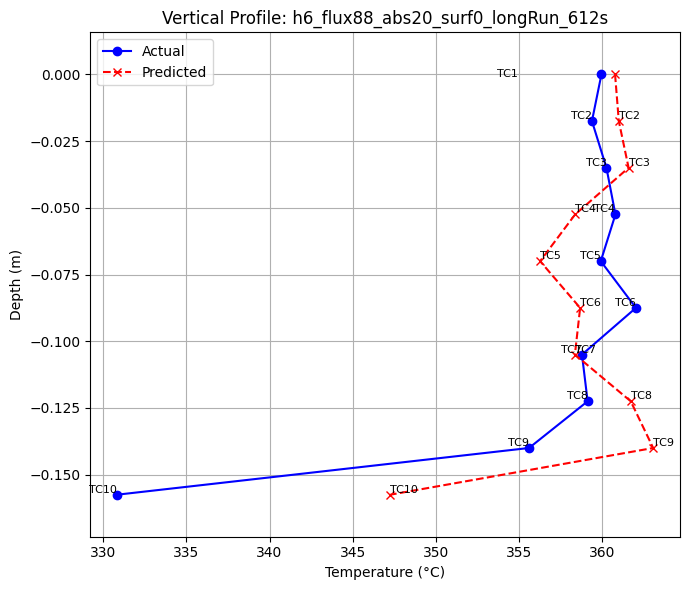

In [64]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    sensor_labels = [f"TC{i+1}" for i in range(10)]
    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 9  # 9 intervals between 10 sensors
    depths = [0 - i * spacing for i in range(10)]  # TC10 at 0, decreasing upwards
    
    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o')
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--')
    plt.gca().invert_yaxis()  # Makes negative values go down
    
    # Add extra space (10%) at top and bottom
    y_margin = total_height * 0.10
    plt.ylim(-total_height - y_margin, 0 + y_margin)
    
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend()

    # Add sensor labels (TC1 on left, others on right)
    for i, label in enumerate(sensor_labels):
        if i == 0:  # TC1 (top sensor) - place text on the left
            plt.text(min(actual[0], predicted[0]) - 5, depths[0], label, 
                     ha='right', va='center', fontsize=8, color='black')
        else:  # Other sensors - default right placement
            plt.text(actual[i], depths[i], label, ha='right', va='bottom', fontsize=8)
            plt.text(predicted[i], depths[i], label, ha='left', va='bottom', fontsize=8)

    plt.grid(True)
    plt.tight_layout()  # Prevent label cutoff
    plt.show()
    
# Use actual values from the dataset for comparison
# actual_values = [360.74, 360.08, 360.53, 360.79, 360.14, 361.79, 358.63, 359.26, 356.22, 335.77]
# actual_values = [359.64,358.86,359.41,359.51,359.17,361.24,358.75,359.21,356.32,336.55]
actual_values = [359.94,359.37,360.24,360.78,359.9,362.01,358.77,359.11,355.59,330.85]
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_wr_surf0_734s")
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_surf0_389s")
plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_surf0_longRun_612s")

In [ ]:
# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 30
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

